# Generate style labels and features for houses

In [9]:
import sys  
sys.path.insert(0, '../visual_home_finder')

import imp
import config, paths, utilities

imp.reload(config)
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import ResNet50

In [10]:
# Find all the csvs in the folder
#list_of_csvs = paths.list_files(config.LISTINGS_PATH, validExts='.csv')
list_of_csvs = [os.path.sep.join([config.LISTINGS_PATH,'Zip_98105.csv']), 
                os.path.sep.join([config.LISTINGS_PATH,'Zip_98115.csv']),
                os.path.sep.join([config.LISTINGS_PATH,'Zip_98117.csv']),
                os.path.sep.join([config.LISTINGS_PATH,'Zip_98107.csv']),
                os.path.sep.join([config.LISTINGS_PATH,'Zip_98103.csv'])]
# list_of_csvs = [os.path.sep.join([config.LISTINGS_PATH,'Zip_98105.csv'])]
img_mean = config.IMG_MEAN

In [11]:
# Loading our home-style feature model
home_model = load_model(os.path.sep.join([config.MODEL_PATH, config.MODEL_NAME]))

# Get home-style features from the model
home_feature_model = Model(inputs = home_model.input, 
                           outputs = home_model.get_layer('dense_4').output)

# Also get Resnet features (for comparison)
resnet_model = ResNet50()
resnet_feature_model = Model(inputs=resnet_model.input,
                            outputs = resnet_model.get_layer('avg_pool').output)

Processing file ../data/raw/house_listings/Zip_98105.csv...
../data/raw/house_listings/98105_1.jpg


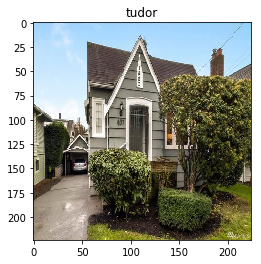

../data/raw/house_listings/98105_2.jpg


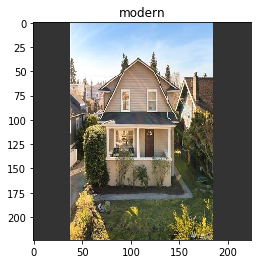

../data/raw/house_listings/98105_3.jpg


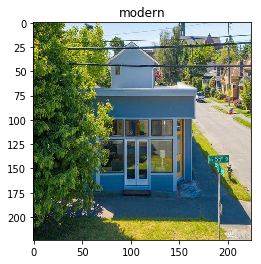

../data/raw/house_listings/98105_4.jpg


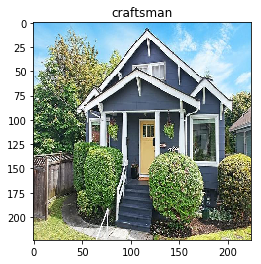

../data/raw/house_listings/98105_5.jpg


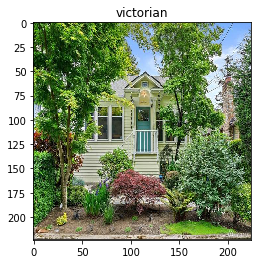

../data/raw/house_listings/98105_6.jpg


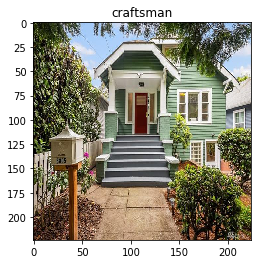

../data/raw/house_listings/98105_7.jpg


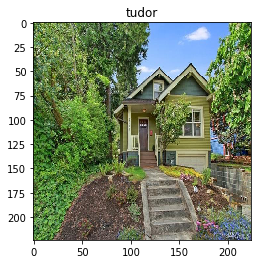

../data/raw/house_listings/98105_8.jpg


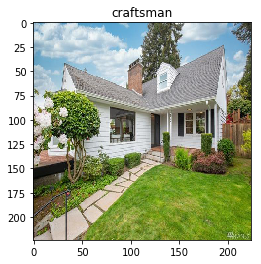

../data/raw/house_listings/98105_9.jpg


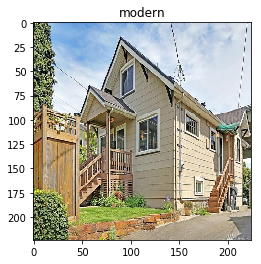

../data/raw/house_listings/98105_10.jpg


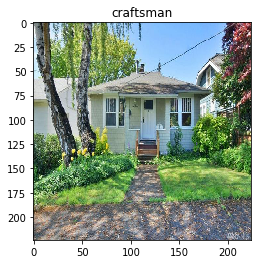

../data/raw/house_listings/98105_11.jpg


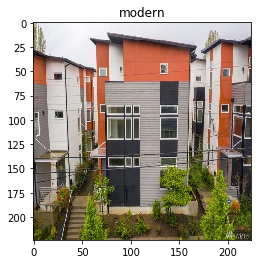

../data/raw/house_listings/98105_12.jpg


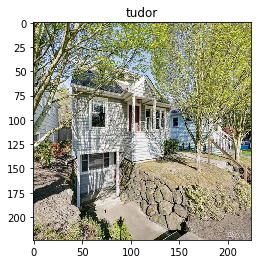

../data/raw/house_listings/98105_13.jpg


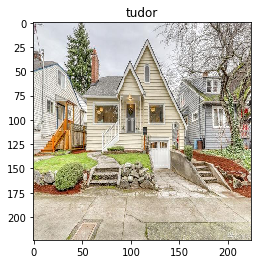

../data/raw/house_listings/98105_14.jpg


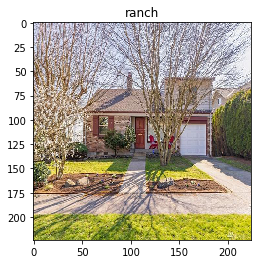

../data/raw/house_listings/98105_15.jpg


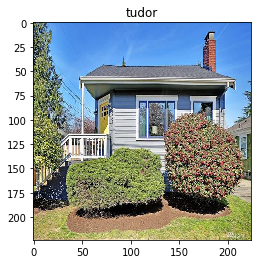

../data/raw/house_listings/98105_16.jpg


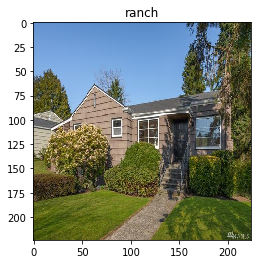

../data/raw/house_listings/98105_17.jpg


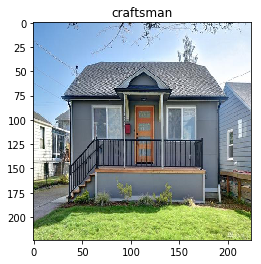

../data/raw/house_listings/98105_18.jpg


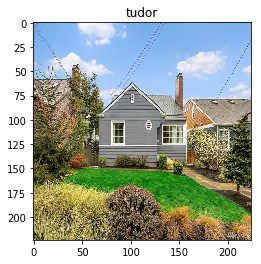

../data/raw/house_listings/98105_19.jpg


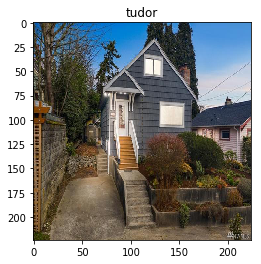

../data/raw/house_listings/98105_20.jpg


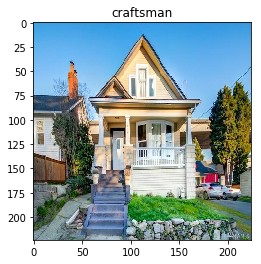

../data/raw/house_listings/98105_21.jpg


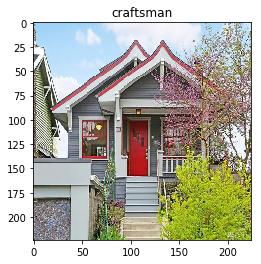

../data/raw/house_listings/98105_22.jpg


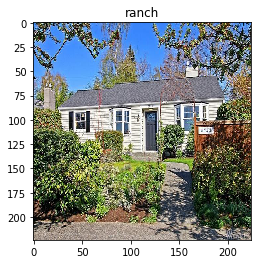

../data/raw/house_listings/98105_23.jpg


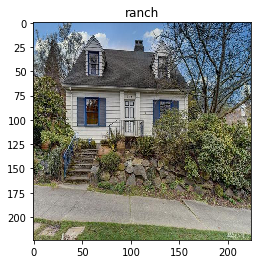

../data/raw/house_listings/98105_24.jpg


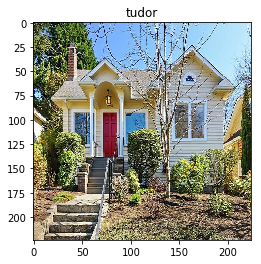

../data/raw/house_listings/98105_25.jpg


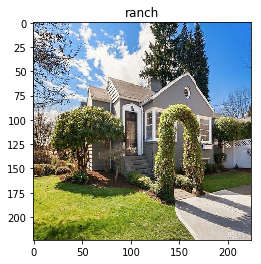

../data/raw/house_listings/98105_26.jpg


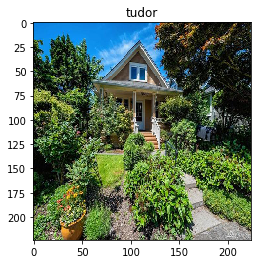

../data/raw/house_listings/98105_27.jpg


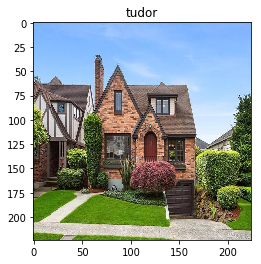

../data/raw/house_listings/98105_28.jpg


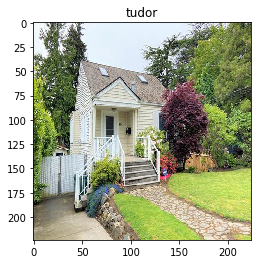

../data/raw/house_listings/98105_29.jpg


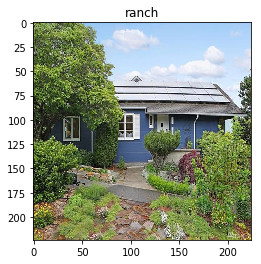

../data/raw/house_listings/98105_30.jpg


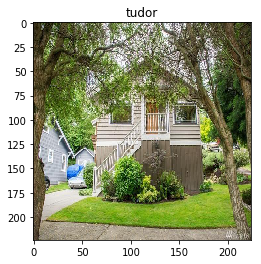

../data/raw/house_listings/98105_31.jpg


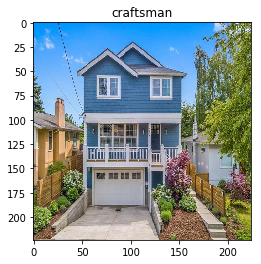

../data/raw/house_listings/98105_32.jpg


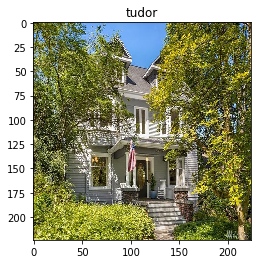

../data/raw/house_listings/98105_33.jpg


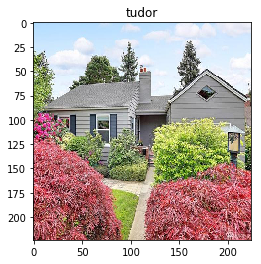

../data/raw/house_listings/98105_34.jpg


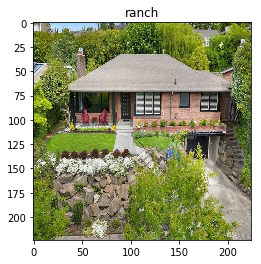

../data/raw/house_listings/98105_35.jpg


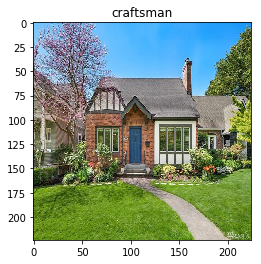

../data/raw/house_listings/98105_36.jpg


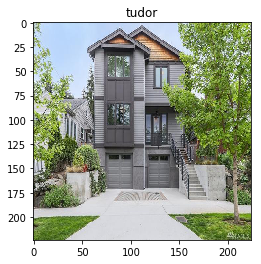

../data/raw/house_listings/98105_37.jpg


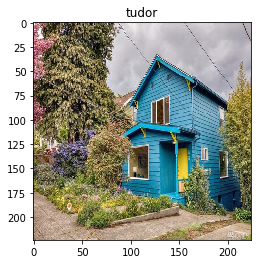

../data/raw/house_listings/98105_38.jpg


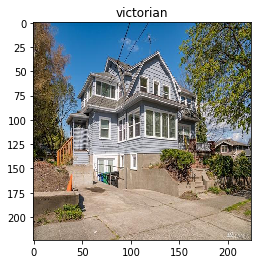

../data/raw/house_listings/98105_39.jpg


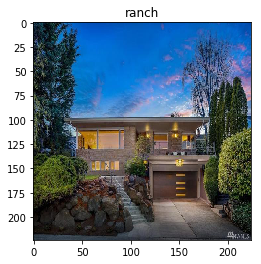

../data/raw/house_listings/98105_40.jpg


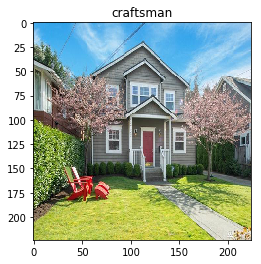

../data/raw/house_listings/98105_41.jpg


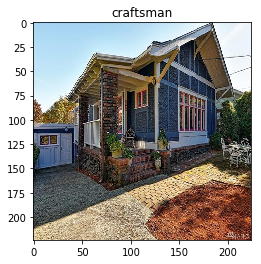

../data/raw/house_listings/98105_42.jpg


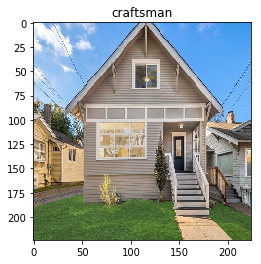

../data/raw/house_listings/98105_43.jpg


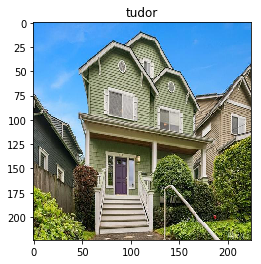

../data/raw/house_listings/98105_44.jpg


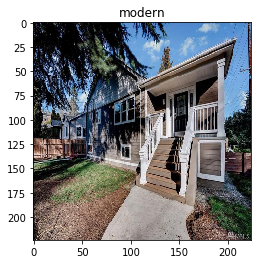

../data/raw/house_listings/98105_45.jpg


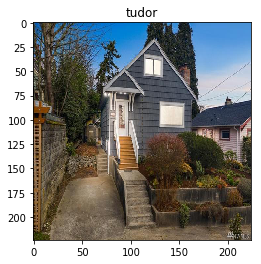

../data/raw/house_listings/98105_46.jpg


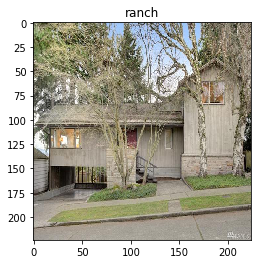

../data/raw/house_listings/98105_47.jpg


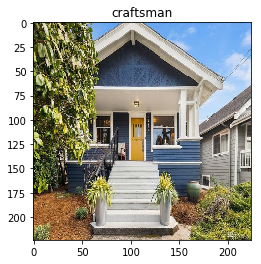

../data/raw/house_listings/98105_48.jpg


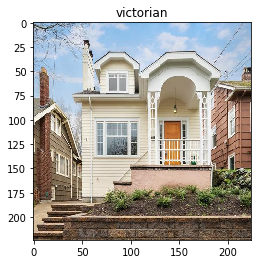

../data/raw/house_listings/98105_49.jpg


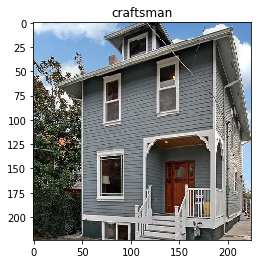

Processing file ../data/raw/house_listings/Zip_98115.csv...


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


Processing file ../data/raw/house_listings/Zip_98117.csv...
Processing file ../data/raw/house_listings/Zip_98107.csv...
Processing file ../data/raw/house_listings/Zip_98103.csv...
Processing complete!


In [12]:
# Got thru each of the listings and get appropriate images
home_listings_df = pd.DataFrame()

count = 0
for listings_file in list_of_csvs:
    
    print('Processing file %s...'%(listings_file))
    
    listings_df = pd.read_csv(listings_file)
    index_column = listings_df['ZIP OR POSTAL CODE'].astype(str)+'_'+ (listings_df.index + 1).astype(str)
    listings_df = listings_df.set_index(index_column)
    
    listings_df['predicted_style'] = ""
    listings_df['home_feature'] = ""
    listings_df['resnet_feature'] = ""
    listings_df.home_feature = listings_df.home_feature.astype('object')
    listings_df.resnet_feature = listings_df.resnet_feature.astype('object')
    
    for ii in index_column:
    
        image_name = os.path.sep.join([config.LISTINGS_PATH, ii+'.jpg'])        
        try:
            img = image.load_img(image_name, target_size = (config.IMAGE_SIZE, config.IMAGE_SIZE))
        except:
            # Remove the particular listing for which image cannot be found
            listings_df = listings_df[listings_df.index != ii]
            print('File %s not found'%image_name)
            continue
        
        orig_img = image.img_to_array(img)
        img = np.expand_dims(orig_img - img_mean, axis = 0)
        home_style_raw = home_model.predict(img)
        
        house_style = config.CLASSES[np.argmax(np.ravel(home_style_raw))]
        listings_df.at[ii, 'predicted_style'] = house_style
        listings_df.at[ii, 'home_feature'] = \
                        np.ravel(home_feature_model.predict(img)).tolist()
        listings_df.at[ii, 'resnet_feature'] = \
                        np.ravel(resnet_feature_model.predict(img)).tolist()
        
        # Display some classifications
        count += 1
        if count<50:
            print(image_name)
            plt.imshow(orig_img/255)
            plt.title(house_style)
            plt.show()
    home_listings_df = home_listings_df.append(listings_df)
print('Processing complete!')

In [13]:
home_listings_df.to_csv(os.path.sep.join([config.FEATURE_PATH, 'home_features_model_6.csv']))

In [14]:
config.MODEL_NAME

'sixth_model_50epochs_5classes_redo.h5'